<a href="https://colab.research.google.com/github/Sultan-manjur/BME/blob/main/PCA_korlam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os                       # OS is for interfacing your own operative system
import pandas as pd             # Pandas is for data analysis and structure manipulation
import matplotlib               # MatPlotLib is for making plots & figures
import matplotlib.pyplot as plt # PyPlot is a subset of the library for making MATLAB-style plots
import h5py
fid = h5py.File(r"dataset_patchcamelyon[1].h5")
X, Y = fid['X'][:], fid['Y'][:]
X = X / 255.
fid.close()


In [ ]:
Y=Y.reshape(-1)

In [ ]:
X.shape

(2500, 96, 96, 3)

In [ ]:
from skimage import color
imgGray = color.rgb2gray(X)

In [ ]:
imgGray.shape

(2500, 96, 96)

Text(0.5, 1.0, 'Grayscale Image')

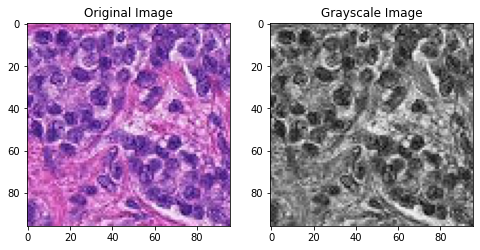

In [ ]:

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(X[0])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(imgGray[0],cmap='gray')
plt.title('Grayscale Image')

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(imgGray,Y,test_size=0.2,shuffle=True, stratify=Y)

In [ ]:
import numpy as np
x_train = x_train[...,np.newaxis]
#X_test = X_test[...,np.newaxis]

In [ ]:
import tensorflow as tf
from tensorflow import keras
data_augmentation = tf.keras.Sequential([
     keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     keras.layers.experimental.preprocessing.RandomRotation(0.2),
     keras.layers.GaussianNoise(0.05),
     keras.layers.experimental.preprocessing.RandomContrast(factor=0.2)
     ])



In [ ]:
i=0
import numpy as np
new_data=[]
new_label=[]
while i<x_train.shape[0]-1:

  image = x_train[i]
  label=y_train[i]

  for k in range(6):
    new_data.append(np.array(data_augmentation(image,training=True)))
    new_label.append(label)
  i=i+1

In [ ]:
final_train=x_train  #np.concatenate([x_train, np.array(new_data)])
final_label=y_train #  np.concatenate([y_train, np.array(new_label)])

In [ ]:
x_train=x_train.reshape(-1,96*96)
x_test=x_test.reshape(-1,96*96)

In [ ]:

x_train.shape

(2000, 9216)

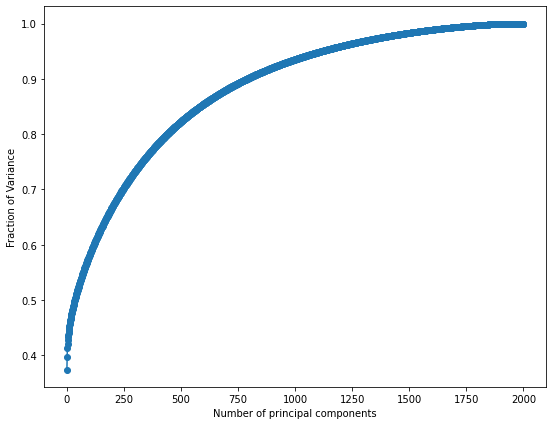

In [ ]:
from sklearn.decomposition import IncrementalPCA,PCA
#plt.style.use('seaborn-white')
pca= PCA()
pca.fit(x_train)
import numpy as np
CUMSUM = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(9,7))
plt.plot(range(1,len(CUMSUM)+1), CUMSUM, marker='o')
plt.xlabel('Number of principal components')
plt.ylabel('Fraction of Variance')
plt.show()


In [ ]:
dmax = np.argmax(CUMSUM >= 0.95) + 1
print(dmax,"components of the total", pca.explained_variance_ratio_.size, "components account for 95% of variance")

1116 components of the total 2000 components account for 95% of variance


In [ ]:

pcaval = PCA(n_components = dmax)
X_train_pca = pcaval.fit_transform(x_train)

In [ ]:
x_test_pca=pcaval.transform(x_test)

In [ ]:
x_test_pca.shape

(500, 1116)

In [ ]:
x_train.shape

(2000, 9216)

In [ ]:
X_train_pca.shape

(2000, 1116)

In [ ]:
X_pca_reconstructed = pcaval.inverse_transform(X_train_pca)

In [ ]:
X_pca_reconstructed.shape

(2000, 9216)

Text(0.5, 1.0, 'Reconstructed image from first 1116 components')

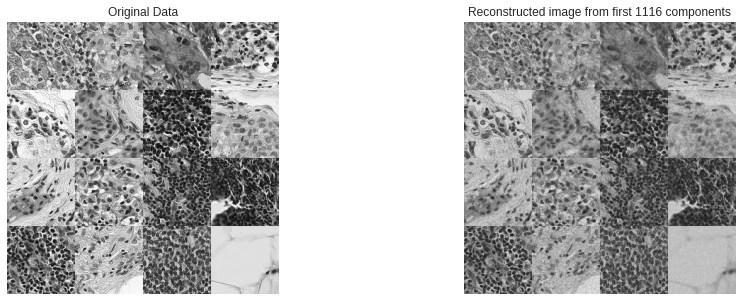

In [ ]:
images0 = []
images1 = []
plt.style.use('seaborn-white')
for k in range(0,4):         # loop across rows...
    row_images0 = []
    row_images1 = []

    for j in range(0,4):     # loop across columns...
        tmp = x_train[10*k+j,:].reshape(96,96)
        row_images0.append(tmp)
        
        tmp = X_pca_reconstructed[10*k+j,:].reshape(96,96)
        row_images1.append(tmp)
    
    tmp = np.concatenate(row_images0, axis=1)
    images0.append(tmp)
    tmp = np.concatenate(row_images1, axis=1)
    images1.append(tmp)


images0 = np.concatenate(images0, axis=0)
images1 = np.concatenate(images1, axis=0)


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(images0, cmap = 'gray')
plt.axis("off")
plt.title('Original Data')

plt.subplot(122)
plt.imshow(images1, cmap = 'gray')
plt.axis("off")
plt.title('Reconstructed image from first 1116 components')

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly'],

        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [50,100],
            'criterion':['entropy','gini']
        }
    },
    'knn':{
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors':[5,10,15],
            'p':[1,2]
        }
    },
    'AdaBoost':{
        'model': AdaBoostClassifier(),
        'params':{
            'n_estimators': [50,100],
            'learning_rate':[0.5,1,2]
        }
    }


}
scores = []

for model_name, mp in model_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_pca,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


,model,best_score,best_params
0,svm,0.7435,"{'kernel': 'rbf', 'C': 1}"
1,random_forest,0.7135,"{'n_estimators': 100, 'criterion': 'gini'}"
2,knn,0.6930,"{'p': 2, 'n_neighbors': 5}"
3,AdaBoost,0.7270,"{'n_estimators': 100, 'learning_rate': 0.5}"


In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

clf1 = RandomForestClassifier(n_estimators=100,criterion='gini')
#clf2=SGDClassifier(loss='log',penalty='l2')
clf3=KNeighborsClassifier(n_neighbors=5,p=2)
clf2=SVC(C=1,kernel="rbf",gamma='auto',probability=True)
clf4=AdaBoostClassifier(n_estimators=100,learning_rate=0.5)

#clf5=GaussianNB(var_smoothing=1e-9)
model = VotingClassifier(estimators=[ ('rf',clf1),('svm',clf2),('knn', clf3),('Adaboost',clf4)], voting='soft')  #, ('sgd', clf2)

In [ ]:
model.fit(X_train_pca,y_train)
y_pred=model.predict(x_test_pca)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.46      0.58       237
           1       0.65      0.89      0.75       263

    accuracy                           0.69       500
   macro avg       0.72      0.67      0.67       500
weighted avg       0.71      0.69      0.67       500



In [ ]:
clf = svm.SVC(gamma='auto',kernel='rbf',C=1,probability=True)
clf.fit(X_train_pca,y_train)
y_pred=clf.predict(x_test_pca)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.46      0.59       237
           1       0.65      0.91      0.76       263

    accuracy                           0.70       500
   macro avg       0.74      0.69      0.68       500
weighted avg       0.74      0.70      0.68       500



Text(0.5, 1.0, 'Confusion Matrix')

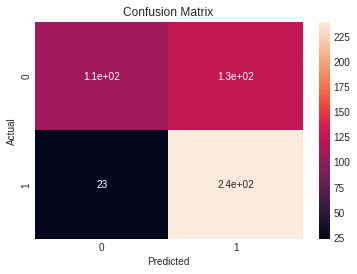

In [ ]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, np.array(y_pred))
#np.fill_diagonal(conf_mat, 0)
plt.figure(figsize=(6,4))
seaborn.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

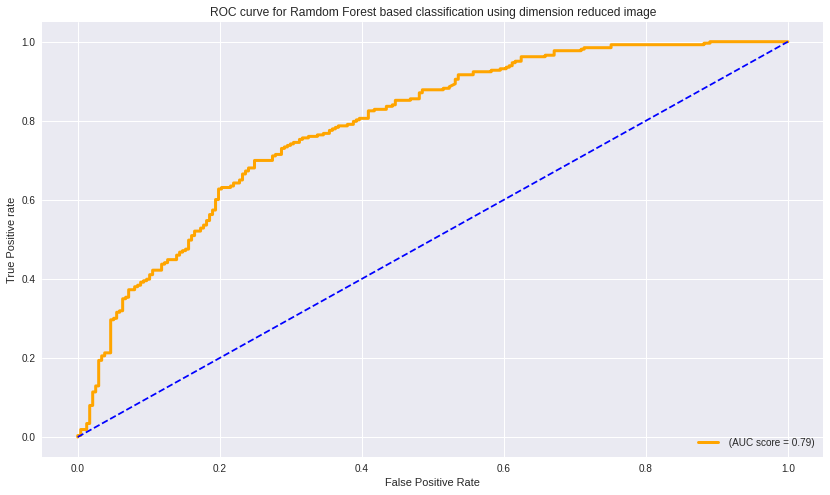

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
y_pred_proba=clf.predict_proba(x_test_pca)
fpr, tpr, T = roc_curve(y_test,y_pred_proba[:,1])
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.style.use('seaborn')
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr,color='orange', linewidth=3.0, label=r' (AUC score = %0.2f)' % (auc_score) )
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve for Ramdom Forest based classification using dimension reduced image')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()